In [ ]:
pip install d2l

In [ ]:
#from d2l import torch as d2l
import torch
import torchvision
from torch import nn
import warnings
from PIL import Image
from d2l import torch as d2l

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/DemoImage'
DemoImage = torchvision.datasets.ImageFolder(data_dir)

In [ ]:
SizeNum = 36

In [ ]:
batch_size = 8
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((SizeNum, SizeNum)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
DemoImage.transform = transformer
data_iter = torch.utils.data.DataLoader(
    DemoImage, batch_size=batch_size,
    shuffle=True)

torch.Size([8, 36, 36, 3])


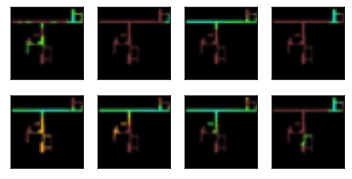

In [ ]:
warnings.filterwarnings('ignore')
d2l.set_figsize((8, 8))
for X, y in data_iter:
    imgs = X[0:8,:,:,:].permute(0, 2, 3, 1)/2+0.5
    print(imgs.shape)
    d2l.show_images(imgs, num_rows=2, num_cols=4)
    break

In [ ]:
p = transforms.Compose([transforms.Resize((SizeNum, SizeNum))])
image = Image.open('/content/drive/MyDrive/data/base_map.jpg')
print('original image size:', image.size)
image = p(image)
print('transform image size:', image.size)
image_3_npArray = np.asarray(image)
print(np.shape(image_3_npArray))
image_3_npArray_3_tensor = torchvision.transforms.ToTensor()(image_3_npArray)
basemap_tensor = image_3_npArray_3_tensor
print(basemap_tensor.type)

basemap_tensor.shape

original image size: (128, 128)
transform image size: (36, 36)
(36, 36, 3)
<built-in method type of Tensor object at 0x7ff2d15f1e10>


torch.Size([3, 36, 36])

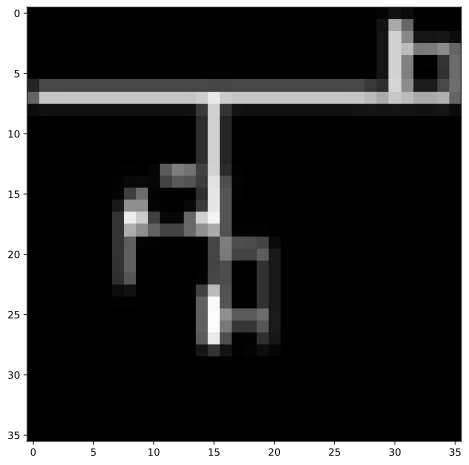

In [ ]:
plt.imshow(  basemap_tensor.cpu().permute(1, 2, 0)  )

## Model Definition

Define Generator

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 36

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 3

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,  out_channels=32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32,  out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128,  out_channels=256, kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,  out_channels=128, kernel_size=2, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128,  out_channels=64, kernel_size=2, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64,  out_channels=32, kernel_size=2, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32,  out_channels=3, kernel_size=2, stride=1, padding=1, output_padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        #print("Input:", x.shape)
        x = self.encoder(x)
        #print("Encoder:", x.shape)
        x = self.decoder(x)
        #print("Decoder:", x.shape)
        return x

In [ ]:
dataiter = iter(data_iter)
sample = dataiter.next()
sample = sample[0]

In [ ]:
model = Generator()
output = model(sample)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

Define Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 36 x 36
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 18 x 18
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 8 x 8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 4 x 4
            nn.Conv2d(ndf * 2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
model = Discriminator()
output = model(sample)
output.shape

torch.Size([8, 1, 1, 1])

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (8): Sigmoid()
  )
)


## Training

In [ ]:
# define helper function to generator the base map tensor
def get_noise(batch_size):
    noise = torch.zeros(batch_size, nz, 36, 36, device=device)
    for i in range(0, noise.shape[0]):
        noise[i] = torch.tensor(basemap_tensor)
    return noise

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(1, nz, 128, 128, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = get_noise(8)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
test = []
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_iter, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #print('output size', netD(real_cpu).shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        noise = get_noise(b_size)
        fake = netG(noise)
        #print('fake shape', fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_iter),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 48 == 0) or ((epoch == num_epochs-1) and (i == len(data_iter)-1)):
            with torch.no_grad():
                fake = netG(get_noise(b_size)).detach().cpu()
                print(fake.shape)
                print(epoch)
            img_list.append(vutils.make_grid(fake, padding=6, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/48]	Loss_D: 1.1696	Loss_G: 1.5519	D(x): 0.8954	D(G(z)): 0.6531 / 0.2118
torch.Size([8, 3, 36, 36])
0
[1/20][0/48]	Loss_D: 0.7673	Loss_G: 1.1868	D(x): 0.7162	D(G(z)): 0.3513 / 0.3052
torch.Size([8, 3, 36, 36])
1
[2/20][0/48]	Loss_D: 0.8283	Loss_G: 0.7647	D(x): 0.5743	D(G(z)): 0.2391 / 0.4655
torch.Size([8, 3, 36, 36])
2
[3/20][0/48]	Loss_D: 1.0875	Loss_G: 1.1569	D(x): 0.8325	D(G(z)): 0.5949 / 0.3145
torch.Size([8, 3, 36, 36])
3
[4/20][0/48]	Loss_D: 1.3025	Loss_G: 0.3538	D(x): 0.3595	D(G(z)): 0.1843 / 0.7020
torch.Size([8, 3, 36, 36])
4
[5/20][0/48]	Loss_D: 1.2027	Loss_G: 1.3324	D(x): 0.6012	D(G(z)): 0.4953 / 0.2638
torch.Size([8, 3, 36, 36])
5
[6/20][0/48]	Loss_D: 0.4957	Loss_G: 1.9183	D(x): 0.7846	D(G(z)): 0.2231 / 0.1469
torch.Size([8, 3, 36, 36])
6
[7/20][0/48]	Loss_D: 0.9304	Loss_G: 1.3585	D(x): 0.4998	D(G(z)): 0.1497 / 0.2571
torch.Size([8, 3, 36, 36])
7
[8/20][0/48]	Loss_D: 0.9747	Loss_G: 1.2447	D(x): 0.9738	D(G(z)): 0.6125 / 0.2880
torch.Size([8

In [ ]:
len(img_list)

21

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


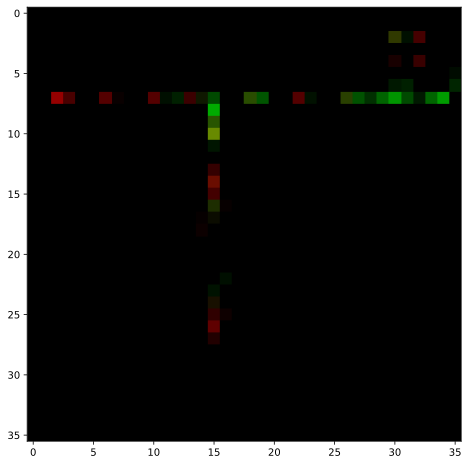

In [ ]:
plt.imshow(  fake[1].cpu().permute(1, 2, 0)  )

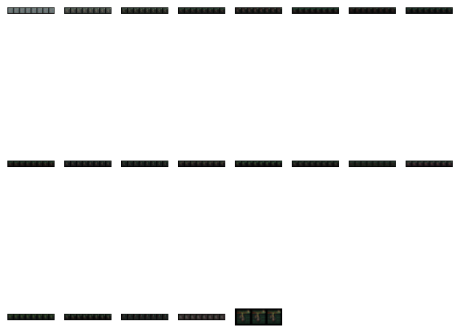

In [ ]:
for ig, x in enumerate(img_list):
    img = img_list[ig]
    plt.subplot(3,8, ig+1)
    plt.axis('off')
    plt.imshow(np.transpose(img,(1,2,0)))

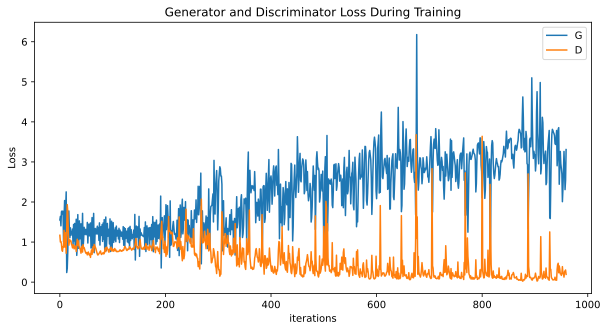

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

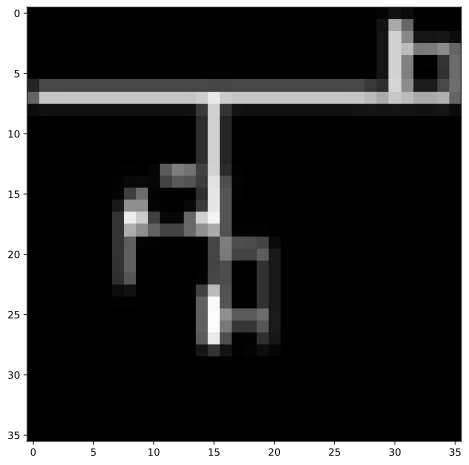

In [ ]:
plt.imshow(  noise[1].cpu().permute(1, 2, 0)  )

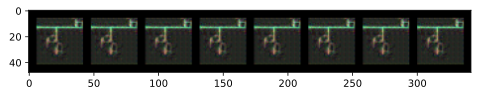

In [ ]:
plt.imshow(  img_list[2].cpu().permute(1, 2, 0)  )

In [ ]:
img_list[1].shape

another_list = img_list[ : -1]

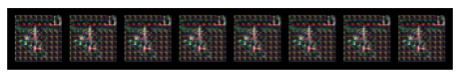

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in another_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_iter))
print(real_batch[0].shape)

test = netG(get_noise(real_batch[0].shape[0])).detach().cpu()


torch.Size([8, 3, 36, 36])


torch.Size([8, 36, 36, 3])


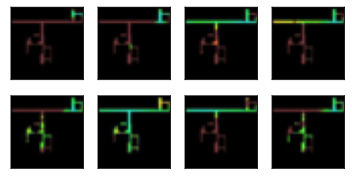

In [ ]:
warnings.filterwarnings('ignore')
d2l.set_figsize((8, 8))
for X in real_batch:
    imgs = X[0:8,:,:,:].permute(0, 2, 3, 1)/2+0.5
    print(imgs.shape)
    d2l.show_images(imgs, num_rows=2, num_cols=4)
    break

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff25d2076a0>,
      dtype=object)

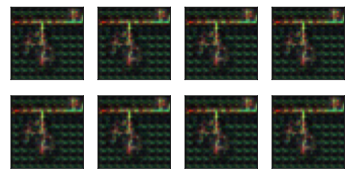

In [ ]:
imgs = test[0:8,:,:,:].permute(0, 2, 3, 1)/2+0.5
d2l.show_images(imgs, num_rows=2, num_cols=4)

In [ ]:
real_batch[0][0].shape


torch.Size([3, 36, 36])

Test real image

In [ ]:
# index available from 1 to batch size
img_index = 3

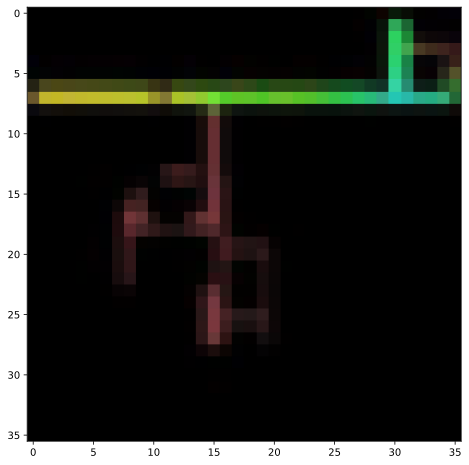

In [ ]:
plt.imshow(real_batch[0][img_index].permute(1, 2, 0)/2+0.5)

Test fake image

torch.Size([36, 36, 3])


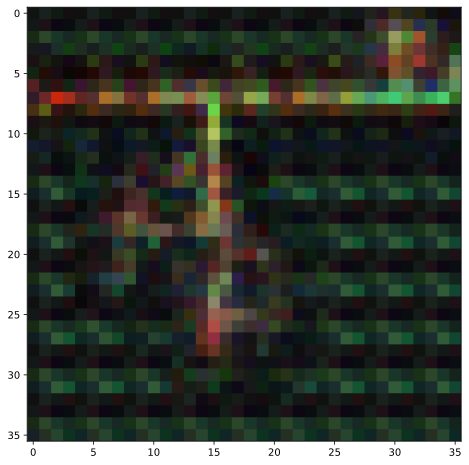

In [ ]:
test_img = test[img_index].permute(1, 2, 0)/2+0.5
print(test_img.shape)
plt.imshow(test_img)